In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import argparse
import numpy as np
from sklearn.metrics import normalized_mutual_info_score
import os

# os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torchvision

from dataloader import mnist_usps, mnist_reverse, FaceLandmarksDataset
from module import Encoder_img, Decoder_img, Classifier, Encoder_Res, Decoder_Res
from eval import predict, cluster_accuracy, balance, calc_FID
from utils import set_seed, AverageMeter, target_distribution, aff, inv_lr_scheduler
import argparse
from PIL import Image

# from MulticoreTSNE import MulticoreTSNE as TSNE
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from tqdm import tqdm, trange


In [2]:
args = argparse.ArgumentParser(description='Process some integers.')
args.bs = 8
args.test_interval = 200
args.lr = 1e-3

args.hidden_dim = 512
# device = 'cuda:2'

In [3]:
def ImageLoader(dataname='celebA'):
    if dataname == 'celebA':
        root_dir = '/data/celebA/CelebA'

        data = pd.read_csv(os.path.join(root_dir, 'Anno/list_attr_celeba.csv'))
        split_data = pd.read_csv(os.path.join(root_dir, 'Anno/list_eval_partition.csv'))
        
        train_data = data[split_data['partition'] == 0]
        valid_data = data[split_data['partition'] == 1]
        test_data = data[split_data['partition'] == 2]
        
    return train_data.reset_index(drop=True), valid_data.reset_index(drop=True), test_data.reset_index(drop=True)

In [4]:
class ImageDataset(Dataset):
    def __init__(self, data, sens_idx, label_idx, root_dir, transform = None):
        self.transform = transform
        self.data = data
        self.sens_idx = sens_idx
        self.label_idx = label_idx
        self.root_dir = root_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.data.iloc[idx, 0]
        img_name = os.path.join(self.root_dir, img_name)
        
        image = Image.open(img_name)
        sens = self.data[self.sens_idx][idx]
        y = self.data[self.label_idx][idx]

        if self.transform:
            image = self.transform(image)

        return  image, (int(sens)+ 1)/2, max(int(y), 0)

In [5]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img_size = 224
crop_size = 224

orig_w = 178
orig_h = 218
orig_min_dim = min(orig_w, orig_h)
mean = [0.485, 0.456, 0.406]
sig = [0.229, 0.224, 0.225]

# transform = transforms.Compose([
#     transforms.RandomResizedCrop(
#         img_size,
#         scale=(0.7, 1.0),
#         ratio=(1.0, 1.3333333333333333),
#         interpolation=2),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

transform = transforms.Compose([
    transforms.CenterCrop(orig_min_dim),
    transforms.Resize(img_size),
    transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


transform_test = transforms.Compose([
    transforms.CenterCrop(orig_min_dim),
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
train_set, valid_set, test_set = ImageLoader()
bs = 16

train_data = ImageDataset(train_set, 'Male', 'Attractive', '/data/celebA/CelebA/Img/img_align_celeba', transform)
trainloader = DataLoader(train_data, batch_size=bs, shuffle=True, drop_last = True, num_workers = 32)

valid_data = ImageDataset(valid_set, 'Male', 'Attractive', '/data/celebA/CelebA/Img/img_align_celeba', transform)
validloader = DataLoader(valid_data, batch_size=bs, shuffle=True, num_workers = 16)

test_data = ImageDataset(test_set, 'Male', 'Attractive', '/data/celebA/CelebA/Img/img_align_celeba', transform)
testloader = DataLoader(test_data, batch_size=bs, shuffle=True, num_workers = 16)

In [7]:
class Classifier(nn.Module):
    def __init__(self, input_dim = 512, hidden_dim = 256, output_dim = 1):
        super(Classifier, self).__init__()
        self.input_dim = input_dim 
        self.dense1 = nn.Linear(input_dim, hidden_dim)
        self.dense2 = nn.Linear(hidden_dim, hidden_dim)
        self.dense3 = nn.Linear(hidden_dim, output_dim)
        self.leakyrelu = nn.ReLU()
        
    def forward(self, x):
        x = self.leakyrelu(self.dense1(x))
        x = self.leakyrelu(self.dense2(x))
        x = self.dense3(x)
        
        return x
    def get_parameters(self):
        return [{"params": self.parameters(), "lr_mult": 1}]

In [8]:
encoder_i = nn.DataParallel(Encoder_img(latent_variable_size = 512)).cuda()
encoder_r = nn.DataParallel(Encoder_img(latent_variable_size = 512)).cuda()

decoder = nn.DataParallel(Decoder_img(latent_variable_size = 1024)).cuda()

cls_y = nn.DataParallel(Classifier(input_dim = 512)).cuda()
cls_a = nn.DataParallel(Classifier(input_dim = 512)).cuda()

In [9]:
torch.load('./save/celeba/VAE/encoder_i.pth')['epoch']

198

In [10]:
encoder_i.load_state_dict(torch.load('./save/celeba/VAE/encoder_i.pth')['state_dict'])
encoder_r.load_state_dict(torch.load('./save/celeba/VAE/encoder_r.pth')['state_dict'])
decoder.load_state_dict(torch.load('./save/celeba/VAE/decoder.pth')['state_dict'])
cls_y.load_state_dict(torch.load('./save/celeba/VAE/cls_y.pth')['state_dict'])
cls_a.load_state_dict(torch.load('./save/celeba/VAE/cls_a.pth')['state_dict'])

<All keys matched successfully>

In [11]:
encoder_i.train();
encoder_r.train();
decoder.train();
cls_y.train();
cls_a.train();

encoder_i.eval();
encoder_r.eval();
decoder.eval();
cls_y.eval();
cls_a.eval();

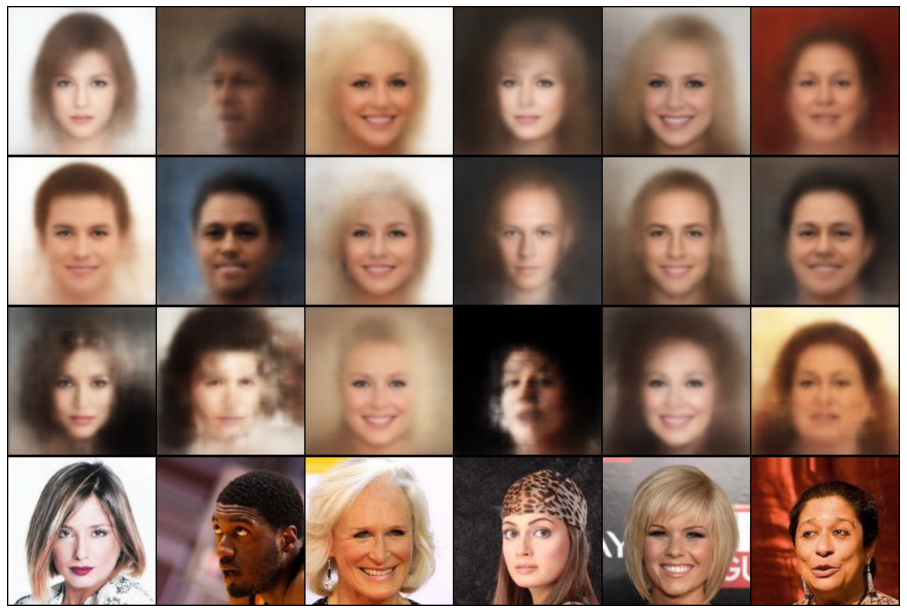

In [12]:
x_batch, s_batch, y_batch = iter(trainloader).next()
x_batch, s_batch, y_batch = x_batch.cuda(), s_batch.cuda().float().view(-1,1), y_batch.cuda().float().view(-1,1)
samples = 6

with torch.no_grad():
    z_i, mu_i, logvar_i = encoder_i(x_batch)
    z_r, mu_r, logvar_r = encoder_r(x_batch)
    z = torch.cat([z_i, z_r], dim = 1)
    recon = decoder(z)

    recon_1 = torchvision.utils.make_grid(recon[: samples], nrow=samples).cpu().permute(1,2,0) 
    image_1 = torchvision.utils.make_grid(x_batch[: samples], nrow=samples).cpu().permute(1,2,0) 
    
#     z = torch.cat([z_i, z_r[torch.randperm(len(z_r)),:]], dim = 1)
    z = torch.cat([z_i, torch.randn_like(z_i).cuda()], dim = 1)
    recon = decoder(z)
    recon_2 = torchvision.utils.make_grid(recon[: samples], nrow=samples).cpu().permute(1,2,0)
    
#     z = torch.cat([z_i[torch.randperm(len(z_i)),:], z_r], dim = 1)
    z = torch.cat([torch.randn_like(z_i).cuda(), z_r], dim = 1)
    recon = decoder(z)
    recon_3 = torchvision.utils.make_grid(recon[: samples], nrow=samples).cpu().permute(1,2,0)

    img = torch.cat([recon_1, recon_2, recon_3, image_1], 0).detach().numpy()

    
    plt.figure(figsize = (16,12))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

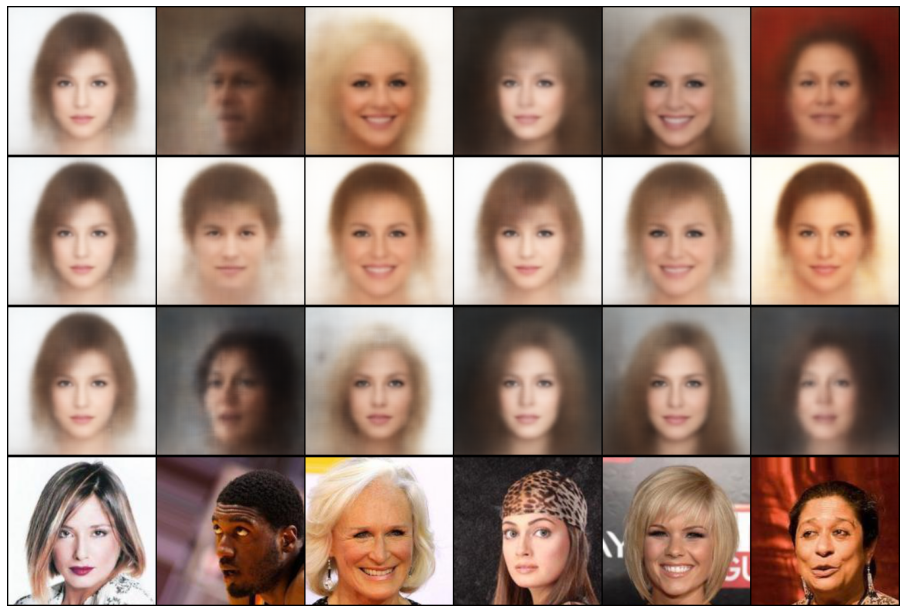

In [13]:
with torch.no_grad():
    z_i, mu_i, logvar_i = encoder_i(x_batch)
    z_r, mu_r, logvar_r = encoder_r(x_batch)
    z = torch.cat([z_i, z_r], dim = 1)
    recon = decoder(z)

    recon_1 = torchvision.utils.make_grid(recon[: samples], nrow=samples).cpu().permute(1,2,0) 
    image_1 = torchvision.utils.make_grid(x_batch[: samples], nrow=samples).cpu().permute(1,2,0) 
    
    z = torch.cat([z_i[0].unsqueeze(0).repeat(bs, 1), z_r], dim = 1)
    recon = decoder(z)
    recon_2 = torchvision.utils.make_grid(recon[: samples], nrow=samples).cpu().permute(1,2,0)
    
#     z_i = encoder_i.module.reparameterize(mu_i[0].unsqueeze(0).repeat(128, 1), \
#                                           logvar_i[0].unsqueeze(0).repeat(128, 1))
    z = torch.cat([z_i, z_r[0].unsqueeze(0).repeat(bs, 1)], dim = 1)
    recon = decoder(z)
    recon_3 = torchvision.utils.make_grid(recon[: samples], nrow=samples).cpu().permute(1,2,0)

    img = torch.cat([recon_1, recon_2, recon_3, image_1], 0).detach().numpy()

    
    plt.figure(figsize = (16,12))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

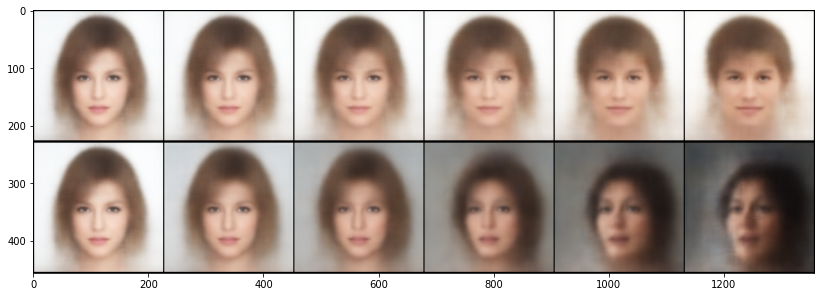

In [14]:
z = torch.cat([z_i, z_r], dim = 1)

recon_lst = [decoder(torch.cat([z_i[0].unsqueeze(0), ((1-r) * z_r[0] +  r * z_r[1]).unsqueeze(0)], dim = 1)) \
                         for r in np.linspace(0, 1, 6)]
recon_lst = torch.cat(recon_lst)

recon_lst2 = [decoder(torch.cat([((1-r) * z_i[0] +  r * z_i[1]).unsqueeze(0), z_r[0].unsqueeze(0)], dim = 1)) \
                         for r in np.linspace(0, 1, 6)]
recon_lst2 = torch.cat(recon_lst2)



recon_1 = torchvision.utils.make_grid(recon_lst).cpu().permute(1,2,0) 
recon_2 = torchvision.utils.make_grid(recon_lst2).cpu().permute(1,2,0) 
plt.figure(figsize = (14, 6))
plt.imshow(torch.cat([recon_1, recon_2], dim = 0).detach().numpy())


## Train Classifier

In [25]:
class Classifier(nn.Module):
    def __init__(self, input_dim = 512, hidden_dim = 256, output_dim = 1):
        super(Classifier, self).__init__()
        self.input_dim = input_dim 
        self.dense1 = nn.Linear(input_dim, hidden_dim)
        self.dense2 = nn.Linear(hidden_dim, hidden_dim)
        self.dense3 = nn.Linear(hidden_dim, hidden_dim)
        self.dense4 = nn.Linear(hidden_dim, output_dim)
        self.leakyrelu = F.leaky_relu
    def forward(self, x):
        x = self.leakyrelu(self.dense1(x))
        x = self.leakyrelu(self.dense2(x))
        x = self.leakyrelu(self.dense3(x))
        x = self.dense4(x)
        
        return x
    def get_parameters(self):
        return [{"params": self.parameters(), "lr_mult": 1}]

In [26]:
y_lst, s_lst, pred_lst = [], [], []

classifier = Classifier(input_dim = 512).cuda()
optimizer_cls = torch.optim.Adam(classifier.get_parameters(), lr = 1e-3, weight_decay=1e-4)
criterion_bce = torch.nn.BCEWithLogitsLoss()

for epoch in tqdm(range(2)):
    step = 0
    acc = 0
    for x_batch, s_batch, y_batch in (trainloader):
        step += 1
        x_batch, s_batch, y_batch = \
            x_batch.cuda().float(), s_batch.cuda().float().view(-1,1), y_batch.cuda().float().view(-1,1)

        z_i, mu_i, logvar_i = encoder_i(x_batch)

        pred_y = classifier(z_i.detach())
        loss_y = criterion_bce(pred_y, y_batch)
        
        optimizer_cls.zero_grad()
        loss_y.backward()
        optimizer_cls.step()
        
        pred_y = torch.sigmoid(pred_y)
        pred_y[pred_y>=0.5] = 1
        pred_y[pred_y<0.5] = 0   
        
        acc += (pred_y == y_batch).float().mean()
    print("ACC : {:.3f}".format(acc/step))



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 1/2 [03:20<03:20, 200.94s/it]

ACC : 0.999


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [06:40<00:00, 200.44s/it]

ACC : 0.999


In [27]:
y_lst, s_lst, pred_lst = [], [], []

classifier.eval()

with torch.no_grad():
    for x_test, s_test, y_test in validloader:
        x_test, s_test, y_test = \
            x_test.cuda().float(), s_test.cuda().float().view(-1,1), y_test.cuda().float().view(-1,1)

        z_i, mu_i, logvar_i = encoder_i(x_test)
        z_r, mu_r, logvar_r = encoder_r(x_test)
        z = torch.cat([z_i, z_r], dim = 1)
        recon = decoder(z)

        pred_y = classifier(z_i)
        
        pred_y = torch.sigmoid(pred_y)
        pred_y[pred_y>=0.5] = 1
        pred_y[pred_y<0.5] = 0       
        
        y_lst.append(y_test)
        s_lst.append(s_test)
        pred_lst.append(pred_y)


y_lst = torch.cat(y_lst)
s_lst = torch.cat(s_lst)
pred_lst = torch.cat(pred_lst)
        

In [28]:
pos_idx = (y_lst == 1)
priv_idx = (s_lst == 1)

tpr_priv = (pred_lst[pos_idx & priv_idx] == y_lst[pos_idx & priv_idx]).float().mean()
fpr_priv = (pred_lst[~pos_idx & priv_idx] == y_lst[~pos_idx & priv_idx]).float().mean()
tpr_unpriv = (pred_lst[pos_idx & ~priv_idx] == y_lst[pos_idx & ~priv_idx]).float().mean()
fpr_unpriv = (pred_lst[~pos_idx & ~priv_idx] == y_lst[~pos_idx & ~priv_idx]).float().mean()

acc = (y_lst == pred_lst).float().mean()
acc_priv = (y_lst[priv_idx] == pred_lst[priv_idx]).float().mean()
acc_unpriv = (y_lst[~priv_idx] == pred_lst[~priv_idx]).float().mean()

In [29]:
print('Acc : {:.3f}, diff : {:.3f}'.format(acc, abs(acc_priv - acc_unpriv)))
print('EOp : {:.3f}, EOd : {:.3f}, DP : {:.3f}'\
      .format(abs(tpr_priv - tpr_unpriv), \
              (abs(tpr_priv - tpr_unpriv) + abs(fpr_priv - fpr_unpriv))/2, \
             abs(pred_lst[priv_idx].mean() - pred_lst[~priv_idx].mean()).item()))

Acc : 0.781, diff : 0.008
EOp : 0.304, EOd : 0.281, DP : 0.447


## Evaluation

In [21]:
y_lst, s_lst, pred_lst = [], [], []

with torch.no_grad():
    for x_test, s_test, y_test in validloader:
        x_test, s_test, y_test = \
            x_test.cuda().float(), s_test.cuda().float().view(-1,1), y_test.cuda().float().view(-1,1)

        z_i, mu_i, logvar_i = encoder_i(x_test)
        z_r, mu_r, logvar_r = encoder_r(x_test)
        z = torch.cat([z_i, z_r], dim = 1)
        recon = decoder(z)

        pred_y = cls_y(z_i)
        pred_a = cls_a(z_r)
        
        pred_a = torch.sigmoid(pred_a)
        pred_a[pred_a>=0.5] = 1
        pred_a[pred_a<0.5] = 0
        pred_y = torch.sigmoid(pred_y)
        pred_y[pred_y>=0.5] = 1
        pred_y[pred_y<0.5] = 0       
        
        y_lst.append(y_test)
        s_lst.append(s_test)
        pred_lst.append(pred_y)


y_lst = torch.cat(y_lst)
s_lst = torch.cat(s_lst)
pred_lst = torch.cat(pred_lst)
        

In [22]:
pos_idx = (y_lst == 1)
priv_idx = (s_lst == 1)

tpr_priv = (pred_lst[pos_idx & priv_idx] == y_lst[pos_idx & priv_idx]).float().mean()
fpr_priv = (pred_lst[~pos_idx & priv_idx] == y_lst[~pos_idx & priv_idx]).float().mean()
tpr_unpriv = (pred_lst[pos_idx & ~priv_idx] == y_lst[pos_idx & ~priv_idx]).float().mean()
fpr_unpriv = (pred_lst[~pos_idx & ~priv_idx] == y_lst[~pos_idx & ~priv_idx]).float().mean()

acc = (y_lst == pred_lst).float().mean()
acc_priv = (y_lst[priv_idx] == pred_lst[priv_idx]).float().mean()
acc_unpriv = (y_lst[~priv_idx] == pred_lst[~priv_idx]).float().mean()

In [23]:
print(tpr_priv)
print(fpr_priv)
print(tpr_unpriv)
print(fpr_unpriv)

tensor(0.5919, device='cuda:0')
tensor(0.8807, device='cuda:0')
tensor(0.8656, device='cuda:0')
tensor(0.5907, device='cuda:0')


In [24]:
print('Acc : {:.3f}, diff : {:.3f}'.format(acc, abs(acc_priv - acc_unpriv)))
print('EOp : {:.3f}, EOd : {:.3f}, DP : {:.3f}'\
      .format(abs(tpr_priv - tpr_unpriv), \
              (abs(tpr_priv - tpr_unpriv) + abs(fpr_priv - fpr_unpriv))/2, \
             abs(pred_lst[priv_idx].mean() - pred_lst[~priv_idx].mean()).item()))

Acc : 0.782, diff : 0.014
EOp : 0.274, EOd : 0.282, DP : 0.449
